In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from infrastructure.utils import calculate_coeffs, calculate_loss_function, plot_decoding
from infrastructure.DelayNetwork import DelayNetwork
import nengo
import numpy as np

/Users/alinalytovchenko/Library/Python/3.9/lib/python/site-packages/nengo/utils/numpy.py:12: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.22.0)
  import scipy.sparse as scipy_sparse


In [2]:
np.random.seed(42)
dt=0.001
run_time = 10.0
readout_synapse = 0.05
inp_high = 10
neuron_type = nengo.AdaptiveLIF(tau_n=0.5, inc_n=0.01)
delay_mode = "discrete"
n_neurons = 300

## Training

In [3]:
with nengo.Network(seed=10) as model:
    white_signal = nengo.processes.WhiteSignal(period=run_time, high=10, rms=0.25, seed=121)
    input_node = nengo.Node(white_signal, size_out=1)
    delay_network = DelayNetwork(num_neurons=n_neurons, readout_synapse=readout_synapse, neuron_type=neuron_type, delay_mode=delay_mode)
    nengo.Connection(input_node, delay_network.ens, synapse=None)

    p_input = nengo.Probe(input_node, sample_every=dt)
    p_activity = nengo.Probe(delay_network.ens.neurons, synapse=readout_synapse, sample_every=dt)
    p_delay_activity = nengo.Probe(delay_network.readout, synapse=None, sample_every=dt)

with nengo.Simulator(model) as sim:
    sim.run(run_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

#### Adding noise to the activity

In [4]:
noise_level = 0.05
rng = np.random.RandomState(42)

activity = sim.data[p_activity]
delay_activity = sim.data[p_delay_activity]

noise_std_activity = noise_level * np.max(np.abs(activity))
noise_std_delay = noise_level * np.max(np.abs(delay_activity))

noisy_activity = activity + rng.normal(0.0, noise_std_activity, size=activity.shape)
noisy_delay_activity = delay_activity + rng.normal(0.0, noise_std_delay, size=delay_activity.shape)

noisy_activity = np.clip(noisy_activity, 0.0, None)
noisy_delay_activity = np.clip(noisy_delay_activity, 0.0, None)

#### Calculating coefficients

In [5]:
delay_coeffs = calculate_coeffs(noisy_delay_activity, sim.data[p_input])
ls_coeffs = calculate_coeffs(noisy_activity, sim.data[p_input])

## Testing on train input

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

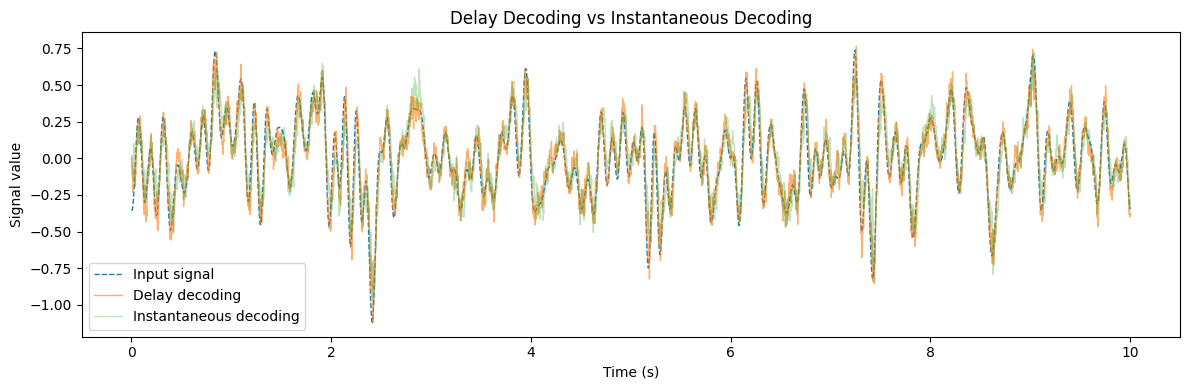

Delay Decoding Loss:  0.005728164154991046
Instantaneous Decoding Loss:  0.014083703779092132


In [6]:
with nengo.Network(seed=10) as model:
    white_signal = nengo.processes.WhiteSignal(period=run_time, high=10, rms=0.25, seed=121)
    input_node = nengo.Node(white_signal, size_out=1)
    delay_network = DelayNetwork(num_neurons=n_neurons, decoder_weights=delay_coeffs, readout_synapse=readout_synapse, neuron_type=neuron_type, delay_mode=delay_mode)
    nengo.Connection(input_node, delay_network.ens, synapse=None)

    p_input = nengo.Probe(input_node, sample_every=dt)
    p_delay_decoded = nengo.Probe(delay_network.readout, synapse=None, sample_every=dt)
    p_activity = nengo.Probe(delay_network.ens.neurons, synapse=readout_synapse, sample_every=dt)

with nengo.Simulator(model) as sim:
    sim.run(run_time)

instantaneous_decoded = sim.data[p_activity] @ ls_coeffs

plot_decoding(sim.trange(), sim.data[p_input], sim.data[p_delay_decoded], instantaneous_decoded, 'Delay Decoding vs Instantaneous Decoding')
print('Delay Decoding Loss: ', calculate_loss_function(sim.data[p_input], sim.data[p_delay_decoded]))
print('Instantaneous Decoding Loss: ', calculate_loss_function(sim.data[p_input], instantaneous_decoded))

## Testing on unseen input

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

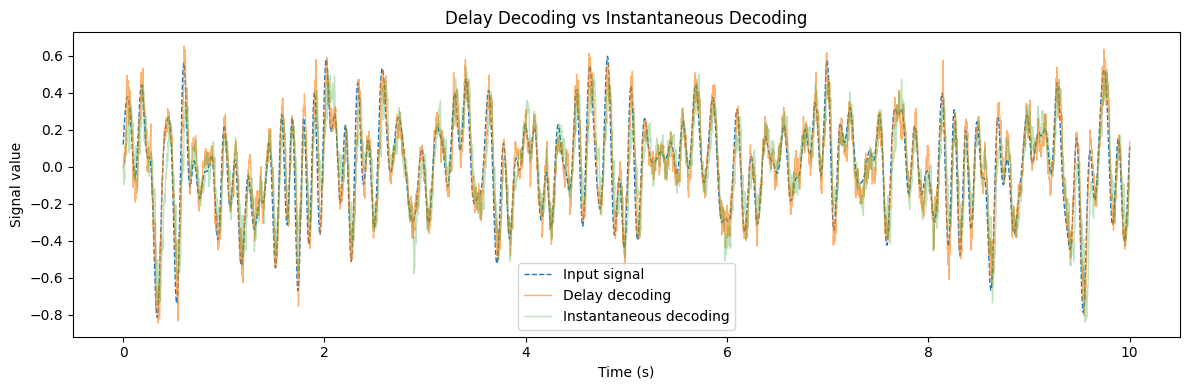

Delay Decoding Loss:  0.00810166686912215
Instantaneous Decoding Loss:  0.021030967250242942


In [7]:
with nengo.Network(seed=10) as model:
    white_signal = nengo.processes.WhiteSignal(period=run_time, high=10, rms=0.25, seed=223)
    input_node = nengo.Node(white_signal, size_out=1)
    delay_network = DelayNetwork(num_neurons=n_neurons, decoder_weights=delay_coeffs, readout_synapse=readout_synapse, neuron_type=neuron_type, delay_mode=delay_mode)
    nengo.Connection(input_node, delay_network.ens, synapse=None)

    p_input = nengo.Probe(input_node, sample_every=dt)
    p_delay_decoded = nengo.Probe(delay_network.readout, synapse=None, sample_every=dt)
    p_activity = nengo.Probe(delay_network.ens.neurons, synapse=readout_synapse, sample_every=dt)

with nengo.Simulator(model) as sim:
    sim.run(run_time)

instantaneous_decoded = sim.data[p_activity] @ ls_coeffs

plot_decoding(sim.trange(), sim.data[p_input], sim.data[p_delay_decoded], instantaneous_decoded,  'Delay Decoding vs Instantaneous Decoding')
print('Delay Decoding Loss: ', calculate_loss_function(sim.data[p_input], sim.data[p_delay_decoded]))
print('Instantaneous Decoding Loss: ', calculate_loss_function(sim.data[p_input], instantaneous_decoded))